<a href="https://colab.research.google.com/github/difli/astra-vsearch-image/blob/main/astra-vsearch-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Image Search with ([CLIP](https://openai.com/research/clip))
Jupyter notebook for image search powered by [Astra Vector Search](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html) and OpenAI [CLIP Model](https://github.com/openai/CLIP).

## OpenAI CLIP Model
CLIP, or "Contrastive Language-Image Pretraining", is an artificial intelligence model developed by OpenAI. The model is trained to understand and associate images with natural language by using a vast number of images and their associated textual descriptions. CLIP can perform tasks such as generating textual descriptions of images or finding images based on given text.

## Astra Vector Search
Astra vector search enables developers to search a database by context or meaning rather than keywords or literal values. This is done by using “embeddings”. Embeddings are a type of representation used in machine learning where high-dimensional or complex data is mapped onto vectors in a lower-dimensional space. These vectors capture the semantic properties of the input data, meaning that similar data points have similar embeddings.

## Demo Summary
The demo showcases the CLIP model, which generates embeddings for images. These embeddings, along with metadata, are stored in Astra DB. Specifically, the embeddings are stored in a column of type Vector. The goal of the demo is to utilize Astra Vector Search to find an image of a house with a swimming pool. The CLIP model generates embeddings based on the search string 'a house with a swimming pool'. These embeddings are then used in a query to find an image that shares similar embeddings with the search string, ultimately displaying an image of a house with a swimming pool.


# Getting Started with this notebook
1. Create a new ***vector search enabled database*** in [Astra](https://astra.datastax.com/).
   1. Create a keyspace
   2. Create a token with permissions to create tables
   3. Download your secure-connect-bundle.zip file.
2. One of the cells below will prompt you to upload the secure connect bundle.
3. Paste in your Astra token where prompted below.

# Setup

In [ ]:
!pip3 install cassandra-driver matplotlib sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=ac12e088575dfffa8916a46cc08db15f96d77edb9ef757a2e2c9a6db13d426ed
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


# Imports

In [ ]:
import os

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from getpass import getpass

# Environment Variables

In [ ]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
ASTRA_DB_TOKEN_BASED_PASSWORD = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


In [ ]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name (e.g. imagevecs): ')

Your Astra DB Keyspace name (e.g. imagevecs): vector_preview


In [ ]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    scb_path = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-vector-search-db.zip to secure-connect-vector-search-db.zip


In [ ]:
SECURE_CONNECT_BUNDLE_PATH = scb_path
ASTRA_CLIENT_ID = 'token'
ASTRA_CLIENT_SECRET = ASTRA_DB_TOKEN_BASED_PASSWORD
KEYSPACE_NAME = ASTRA_DB_KEYSPACE
TABLE_NAME = 'images'

# Connect to Astra DB

In [ ]:
cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

# Drop / Create Schema

In [ ]:
print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY, name TEXT, description TEXT, item_vector VECTOR<FLOAT, 512>)")

print(f"Creating index image_ann_index on table {TABLE_NAME} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS image_ann_index ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'")

print(f"Truncate table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"TRUNCATE TABLE {KEYSPACE_NAME}.{TABLE_NAME}")


Creating table images in keyspace vector_preview
Creating index image_ann_index on table images and inserting example data
Truncate table images in keyspace vector_preview


# Load CLIP model

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

# Generate embeddings from images and load the table with data

In [ ]:
! curl https://raw.githubusercontent.com/difli/astra-vsearch-image/main/images/one.jpg --output one.jpg
! curl https://raw.githubusercontent.com/difli/astra-vsearch-image/main/images/two.jpg --output two.jpg
! curl https://raw.githubusercontent.com/difli/astra-vsearch-image/main/images/three.jpg --output three.jpg
! curl https://raw.githubusercontent.com/difli/astra-vsearch-image/main/images/four.jpg --output four.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96474  100 96474    0     0   567k      0 --:--:-- --:--:-- --:--:--  567k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  104k  100  104k    0     0   573k      0 --:--:-- --:--:-- --:--:--  573k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  143k  100  143k    0     0   763k      0 --:--:-- --:--:-- --:--:--  763k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  109k  100  109k    0     0   660k      0 --:--:-- --:--:-- --:--:--  656k


In [ ]:
img_emb1 = model.encode(Image.open('one.jpg'))
img_emb2 = model.encode(Image.open('two.jpg'))
img_emb3 = model.encode(Image.open('three.jpg'))
img_emb4 = model.encode(Image.open('four.jpg'))

image_data = [
    (1, 'one.jpg', 'description1', img_emb1.tolist()),
    (2, 'two.jpg', 'description2', img_emb2.tolist()),
    (3, 'three.jpg', 'description3', img_emb3.tolist()),
    (4, 'four.jpg', 'description4', img_emb4.tolist())
]

for image in image_data:
    session.execute(f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME} (id, name, description, item_vector) VALUES {image}")

# Generate embeddings from query string

In [ ]:
query_string = "a house with a swimming pool"
text_emb = model.encode(query_string)
print(f"model provided embeddings for the string: 'a house with a swimming pool': {text_emb.tolist()}")


model provided embeddings for the string: 'a house with a swimming pool': [0.2975878417491913, -0.05701418220996857, -0.06703445315361023, 0.11021153628826141, -0.17266632616519928, -0.2119050920009613, 0.16000798344612122, -0.6208814978599548, -0.2307041883468628, -0.052906543016433716, -0.29114019870758057, 0.22570404410362244, -0.18710510432720184, -0.06894761323928833, 0.04774254560470581, -0.18372561037540436, -0.2064921259880066, 0.2224682718515396, 0.066437728703022, -0.004103183746337891, 0.33294329047203064, -0.10105768591165543, 0.08364027738571167, 0.4281950891017914, -0.11602676659822464, 0.1768500655889511, -0.09925183653831482, 0.1447799652814865, 0.048500046133995056, 0.31660914421081543, 0.0018418431282043457, -0.1067505031824112, -0.04233977198600769, 0.1024392768740654, -0.5606356859207153, 0.006011545658111572, 0.12458975613117218, 0.11148964613676071, 0.001642763614654541, 0.1538182497024536, -0.019096627831459045, 0.4148489832878113, -0.2726079523563385, -0.1078368

# Vector search the image that shows a house with a swimming pool

Astra DB vector search query: SELECT name, description, item_vector FROM vector_preview.images ORDER BY item_vector ANN OF [0.2975878417491913, -0.05701418220996857, -0.06703445315361023, 0.11021153628826141, -0.17266632616519928, -0.2119050920009613, 0.16000798344612122, -0.6208814978599548, -0.2307041883468628, -0.052906543016433716, -0.29114019870758057, 0.22570404410362244, -0.18710510432720184, -0.06894761323928833, 0.04774254560470581, -0.18372561037540436, -0.2064921259880066, 0.2224682718515396, 0.066437728703022, -0.004103183746337891, 0.33294329047203064, -0.10105768591165543, 0.08364027738571167, 0.4281950891017914, -0.11602676659822464, 0.1768500655889511, -0.09925183653831482, 0.1447799652814865, 0.048500046133995056, 0.31660914421081543, 0.0018418431282043457, -0.1067505031824112, -0.04233977198600769, 0.1024392768740654, -0.5606356859207153, 0.006011545658111572, 0.12458975613117218, 0.11148964613676071, 0.001642763614654541, 0.1538182497024536, -0.019096627831459045, 0.

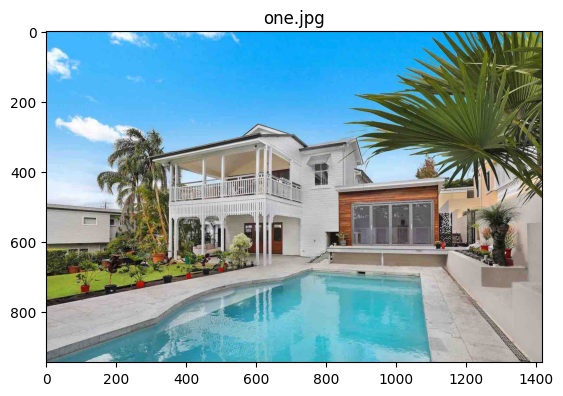

In [ ]:
print(f"Astra DB vector search query: SELECT name, description, item_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1")
for row in session.execute(f"SELECT name, description, item_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1"):
    print("\t" + str(row))
    plt.title(row.name)
    image = mpimg.imread(row.name)
    plt.imshow(image)
    plt.show()